** Описание: Фильтрация документов по тексту** <br>

Цель: реализовать наивный классификатор Байеса для датасета антипорн во время семинара, <br>
так чтобы F1 мера по классу порно была 0.85 и не порно была бы более 0.90 - 1 доп.балл
так чтобы F1 мера по классу порно была 0.9 и не порно была бы более 0.90 - еще 1 доп.балл (в сумме с первым 2 бала)
<br>

Переиспользовать потом наработки данного семинара для решения следующей ДЗ по классификации спама <br>

Дополнительные модули python: <br>
Нужен matplotlib для графиков - но можно и в текстовом виде выводить данные <br>
Опциональные pymorphy2, beautifulsoup4, boilerpipe

In [4]:
from __future__ import division

import json
import base64
import random
from collections import Counter
import os.path
import imp
import gzip

%matplotlib notebook
import matplotlib.pyplot as plt

import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

### Утилиты

#### Декораторы

In [5]:
def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [6]:
from HTMLParser import HTMLParser
import re

class AntiPornHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.__text = []

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self.__text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self.__text.append('\n\n')
        elif tag == 'br':
            self.__text.append('\n')

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self.__text.append('\n\n')

    def text(self):
        return ''.join(self.__text).strip()

@convert2unicode
def html2text_parser(text):
    parser = AntiPornHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [7]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [8]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [9]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [10]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [11]:
def divide_with_check(a, b):
    if a == 0: return 0.0
    elif b == 0: return -a
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = divide_with_check(true_positive, true_positive + false_positive)
    class_recall = divide_with_check(true_positive, true_positive + false_negative)
        
    class_F1 = divide_with_check(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = divide_with_check(true_negative, true_negative + false_negative)
    not_class_recall = divide_with_check(true_negative, true_negative + false_positive)
    
    not_class_F1 = divide_with_check(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )



def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

** Обрабатываем входной файл **
<br>
Входной файл  ./data/antiporn_b64_utf-8.txt 
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не порн, 1 - порн
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

In [12]:
def file2docs(input_file_name):
    result = []            
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:
        for i, line in enumerate(input_file):                
            parts = line.strip().split()

            url_id = int(parts[0])                
            mark = bool(int(parts[1]))
            url = parts[2]

            pageInb64 = parts[3]                
            html_data = base64.b64decode(pageInb64)                
            words = list(html2word(html_data))

            result.append( (url_id, mark, url, words))  
            
            if i % 100 == 0: logging.info("Complete %04d" % i)
    logging.info("Complete %04d" % i)
    return result

In [18]:
DATA_FILE  = './data/antiporn_b64_utf-8.txt.gz'
REPARSE = False

if os.path.exists(DATA_FILE + ".json") and not REPARSE:
    logging.info("File %s.json already exists - load it" % DATA_FILE)
    docs = json.load(open(DATA_FILE + ".json", 'rb'))
else:
    docs = file2docs(DATA_FILE)
    json.dump(docs, open(DATA_FILE + ".json", 'wb'))

21:22:05 INFO:File ./data/antiporn_b64_utf-8.txt.gz.json already exists - load it


** Классификатор: **
Нужно реализовать

In [19]:
f = Counter()
f.values()

[]

In [20]:
import math
import numpy as np

In [56]:
import math

class BayesClassifaer:
    
    def __init__(self):
        pass
    
    
    def sum_ln_probs(self, words):
        sum_lns = 0
        for word in words:
            if self.f[word] > 0 and self.t[word] > 0:
                sum_lns += math.log(self.t[word] / self.f[word])
        return sum_lns / len(words)
        
    def predict_rand(self, words):        
        random.seed(hash(len(words))) #чтобы для заданного документа результат был бы постоянен
        return random.random()
    
    def is_class(self, words, threshold):
        return self.predict(words) > threshold

    def predict(self, words):
        #TODO вставить код
        return self.sum_ln_probs(words)
        
    def predict_all(self, docs):
        res = []
        for (url_id, mark, url, words) in docs:
            prediction = self.predict(words)
            res.append( (url_id, mark, url, prediction) )
        return res
        
    def train(self, docs):                
        t = Counter()
        f = Counter()
        for i, (url_id, mark, url, words) in enumerate(docs):                            
            #TODO вставить код обучения
            #добавить проверку стоп слов
            for word in words:
                if len(word) > 3 and len(word) < 15:
                    if mark:
                        t[word] += 1
                    else:
                        f[word] += 1
            if i % 1000 == 0: logging.info("Complete %04d docs" % i)
        self.t = t
        self.f = f
        logging.info("Complete %04d docs" % i)
        

In [57]:
classifier = BayesClassifaer()
classifier.train(docs)

21:31:08 INFO:Complete 0000 docs
21:31:09 INFO:Complete 1000 docs
21:31:10 INFO:Complete 2000 docs
21:31:11 INFO:Complete 3000 docs
21:31:11 INFO:Complete 4000 docs
21:31:11 INFO:Complete 4214 docs


In [ ]:
#Вывести слова, которые чаще всего встретились в классе порно

In [ ]:
#Вывести слова, которые чаще всего встретились в классе не порно

In [ ]:
#Напечатать кол-во слов встретившихся в каждом классе

In [ ]:
#Попробывать предсказать порнографичность пары документов

#doc_i = 3847
doc_i = 4159
doc = docs[doc_i]
print doc[0:3]
classifier.predict(docs[doc_i][3])

In [ ]:
#Посмотреть, что предсказывается для слова 'порно'
word = u'порно'
classifier.predict([word])

** Собираем статисику по порогам **

In [23]:
def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.05, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])
        if trace: print threshold, r[0], r[1]
    plot_stats(x, y_p, "Porn Result")
    plot_stats(x, y_n, "Not porn Result")    

** Рисуем графики **

-1 (0.422542460113227, 1.0, 0.5940665701881331) (1.0, 0.12786630392537893, 0.22674017918676773)
-0.95 (0.4347019867549669, 0.9993909866017052, 0.6058704079748939) (0.9977272727272727, 0.17061795569374272, 0.29140391636242946)
-0.9 (0.4550499445061043, 0.9987819732034104, 0.6252382767823103) (0.9967266775777414, 0.23668869024485037, 0.3825376884422111)
-0.85 (0.4797891036906854, 0.997563946406821, 0.6479430379746834) (0.9950062421972534, 0.3097551496307812, 0.4724362774155306)
-0.8 (0.5101277656590838, 0.9969549330085262, 0.6749123891981035) (0.9950298210735586, 0.3890400310921104, 0.5593741268510758)
-0.75 (0.5478027507547802, 0.9945188794153471, 0.7064676616915422) (0.9927066450567261, 0.4760979401476875, 0.643551352771211)
-0.7 (0.5861694424330196, 0.9859926918392204, 0.7352406902815624) (0.9841706813489333, 0.5557714729887291, 0.7103825136612022)
-0.65 (0.6335305719921105, 0.9780755176613886, 0.7689729470912138) (0.9785714285714285, 0.6389428682471823, 0.7731013402304255)
-0.6 (0.68

<IPython.core.display.Javascript object>


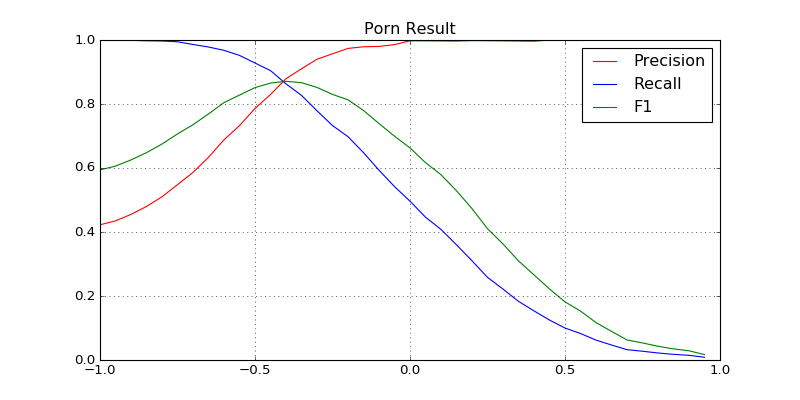

<IPython.core.display.Javascript object>


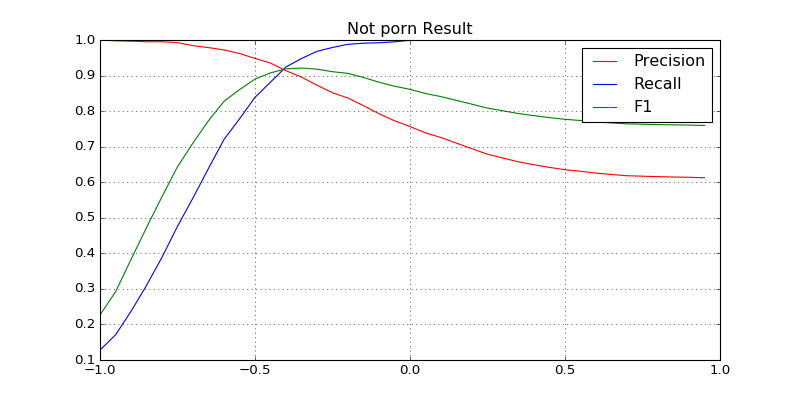

In [58]:
plot_results(docs, trace=1)